<a href="https://colab.research.google.com/github/imnotjohn/cityscience/blob/main/MAS_552_Mobility_Spring2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shared autonomous micro-mobility
In today's workshop, we will model the performance and environmental impact of community-scale systems of shared autonomous micro-mobility systems.

For this, we will use the results from our previous work: [Simulation study on the fleet performance of shared autonomous bicycles](https://arxiv.org/abs/2106.09694). It is an agent based simulation based on Bluebikes data for the Boston region that compares the performance of autobomous bicycles with current station-based and dockless systems.

If you're interested in learning more about this simulation, the code is open-source and [available on GitHub](https://github.com/NaroaCS/AutonomousBicycleSimulation), and we have built a [documentation website](https://micro-mobility-abm.netlify.app/) that will guide you on how to use it.


> You can also watch this short [video](https://www.youtube.com/watch?v=xlwVoLSkZzY&feature=emb_title) about our research!


*Research by: Naroa Coretti, Iñigo Martinez, Luis Alonso, Kent Larson*


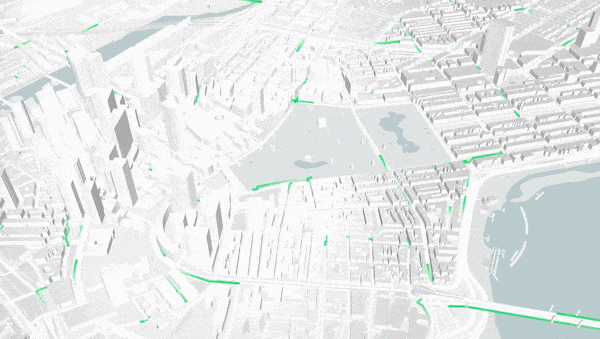

❗❗❗Before we start, save a copy of this Collab to your Drive ❗❗❗

> **File > Save a copy to Drive**



# Importing data

In [ ]:
#Import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Save the links to the .csv files stored on GitHub

#Weekly averages with parameter variation
url_sb_m='https://raw.githubusercontent.com/NaroaCS/data/main/simulation-test-results/stationbased_metrics_multiple.csv'
url_dl_m= 'https://raw.githubusercontent.com/NaroaCS/data/main/simulation-test-results/dockless_metrics_multiple.csv'
url_aut_m = 'https://raw.githubusercontent.com/NaroaCS/data/main/simulation-test-results/autonomous_no_rebalancing_metrics_multiple.csv'

#Data on environmental impacts
url_env='https://raw.githubusercontent.com/NaroaCS/data/main/environmental-impacts/MAS552_env_impacts.csv'

#Store the dataset as a Pandas dataframe
sb_raw = pd.read_csv(url_sb_m)
dl_raw  = pd.read_csv(url_dl_m)
aut_raw  = pd.read_csv(url_aut_m)
env = pd.read_csv(url_env)

#Clean the data
sb_clean=sb_raw.drop(sb_raw.columns.difference(['run', 'num_bikes', 'walk_radius', 'riding_speed', 'walking_speed', 'magic_beta', 'magic_min_bikes','user_trips_file', 'num_users','time_walk_origin_avg','time_walk_destination_avg', 'time_ride_avg', 'time_trip_avg','walk_over_10min_origin.user', 'walk_over_15min_origin.user','walk_over_10min_destination.user', 'walk_over_15min_destination.user', 'served_trips', 'unserved_trips_no_walkable_stations','unserved_trips_no_bikes', 'unserved_trips', 'num_magic_bikes','num_magic_docks', 'num_trips_bike_day', 'num_used_bikes', 'vkt_total', 'vkt_total.bike', 'time_in_use.time', 'time_stop.time']), 1);
dl_clean =dl_raw.drop(dl_raw.columns.difference(['run','num_bikes', 'walk_radius', 'riding_speed','walking_speed', 'user_trips_file', 'time_total', 'time_total.bike', 'num_users', 'time_walk_avg', 'time_ride_avg', 'time_trip_avg','walk_over_10min.user', 'walk_over_15min.user','served_trips', 'unserved_trips', 'num_trips_bike_day','num_used_bikes', 'vkt_total', 'vkt_total.bike','time_in_use.time','time_stop.time']),1);
aut_clean =aut_raw.drop(aut_raw.columns.difference(['run','num_bikes', 'autonomous_radius', 'riding_speed', 'autonomous_speed', 'battery_min_level','battery_autonomy', 'battery_charge_time', 'user_trips_file','num_users', 'time_wait_avg', 'time_ride_avg', 'time_trip_avg', 'wait_over_10min.user','wait_over_15min.user','served_trips', 'unserved_trips','num_trips_bike_day', 'num_used_bikes', 'vkt_pickup', 'vkt_charging','num_recharges', 'vkt_total', 'vkt_total.bike', 'vkt_in_use.dist',  'vkt_pickup.dist','vkt_charging.dist', 'time_in_use.time', 'time_pickup.time', 'time_charging.time', 'time_stop.time','num_recharges_day']),1);

#Filtering some values
sb_nom= sb_clean.loc[(sb_clean['num_bikes']==3500) & (sb_clean['walk_radius']==300) & (sb_clean['riding_speed']==10.2) & (sb_clean['walking_speed']==5) & (sb_clean['magic_beta']==90) & (sb_clean['magic_min_bikes']==3) & (sb_clean['user_trips_file']==0)]
dl_nom = dl_clean.loc[(dl_clean['num_bikes']==8000) & (dl_clean['walk_radius']==300) & (dl_clean['riding_speed']==10.2) & (dl_clean['walking_speed']==5) & (dl_clean['user_trips_file']==0)]
aut_nom_temp =  aut_clean.loc[ (aut_clean['riding_speed']==10.2) &(aut_clean['battery_autonomy']==70)& (aut_clean['autonomous_radius']==2000)& (aut_clean['battery_min_level']==15) &(aut_clean['battery_charge_time']==4.5)& (aut_clean['user_trips_file']==0)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


#Exercise: System design

We will define the systems by defining two main variables:


*   Fleet size: By defining the **number of vehicles**, we define the user experience and efficiency of the system, which in turn will determine the system's environmental impact. For example, adding bikes will provide a better user experience with shorter waiting times and more served trips. However, the system will also be less efficient and has a higher environmental impact.

*   Vehicle design: We will define the type of vehicle by determining the **speed** at which it travels. For example, a low speed could represent an autonomous scooter, medium values could represent a bike, while larger values can represent a three or four-wheeler. The fleeet will only have one type of vehicle.

You will need to add the results to the [slides](https://docs.google.com/presentation/d/1UwME4cDbbSWtZJLnCZKVbQtj31f5s_TrGUUqT0pnwig/edit?usp=sharing) that have your group name.


* Explain in a few words why you took the design decisions (Step 2)

* Add the performance parameters (Step 3)

* Add the values and the plot of the environmental impact (Step 4)


## Step 1: Analyzing the data

Let's first take a look into the data that we have

In [ ]:
aut_nom_temp.head()

,run,num_bikes,autonomous_radius,riding_speed,autonomous_speed,battery_min_level,battery_autonomy,battery_charge_time,user_trips_file,num_users,time_wait_avg,time_ride_avg,time_trip_avg,wait_over_10min.user,wait_over_15min.user,served_trips,unserved_trips,num_trips_bike_day,num_used_bikes,vkt_pickup,vkt_charging,num_recharges,vkt_total,vkt_total.bike,vkt_in_use.dist,vkt_pickup.dist,vkt_charging.dist,time_in_use.time,time_pickup.time,time_charging.time,time_stop.time,num_recharges_day
3,4,300,2000,10.2,5.0,15,70,4.5,0,62192,702.797585,820.087132,1522.884717,36.369630,23.707229,45219,16973,21.533071,301,44306.104167,168.534722,754,149544.612222,498.482041,70.259952,29.627349,0.112699,20.438651,17.581962,0.066880,61.912508,107.715354
9,10,500,2000,10.2,5.0,15,70,4.5,0,62192,536.116600,833.466292,1369.582892,31.767751,18.446102,55892,6300,15.969301,497,41776.556944,160.008333,714,173924.842944,347.849686,75.888111,24.019891,0.091999,15.404947,9.946898,0.038098,74.610057,102.001012
15,16,600,2000,10.2,5.0,15,70,4.5,0,62192,490.378423,837.642203,1328.020626,29.166131,16.434590,57840,4352,13.771565,592,39544.326389,151.504167,656,176968.634722,294.947725,77.569002,22.345387,0.085611,13.351440,7.846174,0.030061,78.772325,93.715215
21,22,700,2000,10.2,5.0,15,70,4.5,0,62192,447.569116,840.548143,1288.117259,26.439092,14.315346,59552,2640,12.153590,685,37160.862500,142.784722,620,179129.895722,255.899851,79.175086,20.745204,0.079710,11.823701,6.319937,0.024283,81.832079,88.572307
27,28,800,2000,10.2,5.0,15,70,4.5,0,62192,406.110921,842.718660,1248.829581,23.462825,11.876126,60674,1518,10.834750,778,34352.979167,131.034722,574,179355.497889,224.194372,80.773372,19.153569,0.073059,10.567878,5.112101,0.019499,84.300522,82.000814


We can do some basic plots that will help us to understand the impact of each parameter and their relationships

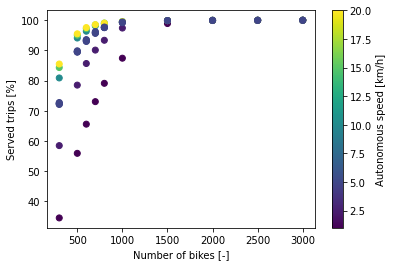

In [ ]:
#Plot 1 - Served trips vs number of bikes and speed
plt.scatter(x=aut_nom_temp['num_bikes'], y=aut_nom_temp['served_trips']/aut_nom_temp['num_users']*100, c=aut_nom_temp['autonomous_speed'])
plt.xlabel('Number of bikes [-]')
plt.ylabel('Served trips [%]')
cb=plt.colorbar()
cb.set_label('Autonomous speed [km/h]')
plt.show()

#Plot 2 - Wait times vs number of bikes and speed
# Your code here !


## Step 2: Choose the parameters for your system

Now that we have an intuition on the relationship between the different variables, it is time to design our system. In your groups, decide which kind of vehicle you will be modeling and the fleet size you consider appropriate (i.e., how you prioritize user experience vs. system efficiency, etc.).
You can run some iterations by checking the results in the following sections.


First, we need to extract the possible values for the parameters from which you will choose your design parameters.

In [ ]:
#Checking the range of possible values for the parameters

#Fleet size
fleet_sizes= aut_nom_temp['num_bikes'].unique()
fleet_sizes.sort()
print('Number of bikes:', fleet_sizes)

#Autonomous driving speed
autonomous_speed=aut_nom_temp['autonomous_speed'].unique()
autonomous_speed.sort()
print('Autonomous speed [km/h]:',autonomous_speed)


Number of bikes: [ 300  500  600  700  800 1000 1500 2000 2500 3000]
Autonomous speed [km/h]: [ 1.   2.5  5.  10.  15.  20. ]


In [ ]:
#Select your values!

aut_nom =  aut_nom_temp.loc[ (aut_nom_temp['num_bikes']== 300)  &(aut_nom_temp['autonomous_speed']== 1) ]

display(aut_nom)


,run,num_bikes,autonomous_radius,riding_speed,autonomous_speed,battery_min_level,battery_autonomy,battery_charge_time,user_trips_file,num_users,time_wait_avg,time_ride_avg,time_trip_avg,wait_over_10min.user,wait_over_15min.user,served_trips,unserved_trips,num_trips_bike_day,num_used_bikes,vkt_pickup,vkt_charging,num_recharges,vkt_total,vkt_total.bike,vkt_in_use.dist,vkt_pickup.dist,vkt_charging.dist,time_in_use.time,time_pickup.time,time_charging.time,time_stop.time,num_recharges_day
66,67,300,2000,10.2,1.0,15,70,4.5,0,62192,4555.437696,815.294925,5370.732621,32.679444,31.404361,21419,40773,10.199625,294,27208.034167,104.573889,463,76790.547056,255.96849,64.43233,35.431489,0.136181,9.624656,53.98473,0.20749,36.183124,66.143513


## Step 3: Analyze the performance of your system

These are the input metrics that you have defined:

In [ ]:
print('Fleet size = number of bikes =',aut_nom.iloc[0]['num_bikes'], "[-]" )
print('Autonomous driving speed =', aut_nom.iloc[0]['autonomous_speed'], "[km/h]")

Fleet size = number of bikes = 300.0 [-]
Autonomous driving speed = 1.0 [km/h]


With these inputs, system will provide the following the **user experience**:



In [ ]:
print('Average wait time = %.2f ' % (aut_nom.iloc[0]['time_wait_avg']/60), '[min]')
print('People waiting more than 10 min = %.2f' % aut_nom.iloc[0]['wait_over_10min.user'] ,'[%]')
print('People waiting more than 15 min = %.2f' % aut_nom.iloc[0]['wait_over_15min.user'], "[%]")
print('Percentage of served trips = %.2f' % (aut_nom.iloc[0]['served_trips']/aut_nom.iloc[0]['num_users']*100) , "[%]")
print('Percentage of unserved trips = %.2f ' % (aut_nom.iloc[0]['unserved_trips']/aut_nom.iloc[0]['num_users']*100) , "[%]")

Average wait time = 75.92  [min]
People waiting more than 10 min = 32.68 [%]
People waiting more than 15 min = 31.40 [%]
Percentage of served trips = 34.44 [%]
Percentage of unserved trips = 65.56  [%]


Now, let's analyze the **system performance** :

Number of trips per bike and day = 10.20 [-]
Percetnage of bikes used = 98.00 [%]
Number of charges per day (whole fleet) = 66.14 [-]
Vehicle kilometers travelled by the fleet= 76791 [km]
Vehicle kilometers in use=  49478 [km]
Vehicle kilometers travelled per bike=  256 [km]


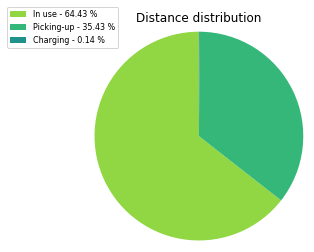

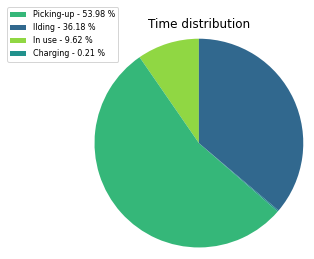

In [ ]:
print('Number of trips per bike and day = %.2f' % aut_nom.iloc[0]['num_trips_bike_day'], "[-]")
print('Percetnage of bikes used = %.2f' % (aut_nom.iloc[0]['num_used_bikes']/aut_nom.iloc[0]['num_bikes']*100), "[%]")
print('Number of charges per day (whole fleet) = %.2f' % aut_nom.iloc[0]['num_recharges_day'], '[-]')
print('Vehicle kilometers travelled by the fleet= %.0f' % aut_nom.iloc[0]['vkt_total'], "[km]")
dist_in_use=aut_nom.iloc[0]['vkt_total']*aut_nom.iloc[0]['vkt_in_use.dist']/100
print('Vehicle kilometers in use=  %.0f' % dist_in_use, "[km]")
print('Vehicle kilometers travelled per bike=  %.0f' % aut_nom.iloc[0]['vkt_total.bike'], "[km]")

color = ['#90d743','#35b779','#21918c','#31688e']

#Plotting distance distibution
x_d = 'In use', 'Picking-up', 'Charging'
y_d = [aut_nom.iloc[0]['vkt_in_use.dist'], aut_nom.iloc[0]['vkt_pickup.dist'],aut_nom.iloc[0]['vkt_charging.dist']]
patches, texts = plt.pie(y_d, colors=color, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x_d, y_d)]
sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y_d),
                                          key=lambda x_d: x_d[2],
                                          reverse=True))
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.4, 1.),
           fontsize=8)
plt.title('Distance distribution')
plt.show();

#Plotting time distribution
x_t = 'In use', 'Picking-up', 'Charging', 'Ilding'
y_t = [aut_nom.iloc[0]['time_in_use.time'], aut_nom.iloc[0]['time_pickup.time'],aut_nom.iloc[0]['time_charging.time'], aut_nom.iloc[0]['time_stop.time']]
patches, texts = plt.pie(y_t, colors=color, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x_t, y_t)]
sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y_t),
                                          key=lambda x_t: x_t[2],
                                          reverse=True))
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.4, 1.),
           fontsize=8)
plt.title('Time distribution')
plt.show();


If you are not happy with the results, you can change your design parameters and **run a few iterations** until you like the performance.

Keep in mind that the scatter plots in **Step 1** might be helpful to understand the impact of each parameter.

## Step 4: Environmental impact analysis

In this last section, we will try to make a simple estimate of the environmental impact of the systems that you have designed.
For that, we will use results from a recent study from our group, [Can autonomy make bicycle-sharing systems more sustainable? Environmental impact analysis of an emerging mobility technology](https://arxiv.org/abs/2202.12405)

*NOTE: Even if Life Cycle Assessment (LCA) is a valuable tool for understanding the environmental impacts of products and services, the results are heavily influenced by methodological choices. While we have tried to limit the uncertainties by performing sensitivity analyses in our study, it should be kept in mind that environmental impacts are very case-specific.*


In [ ]:
#The environmental impact will be based on the number of trips per bike and day in your system
num_trips_bike_day= aut_nom.iloc[0]['num_trips_bike_day']
num_trips_bike_day=round(num_trips_bike_day,8)
print('Trips/bike/day in your system: ',num_trips_bike_day)

Trips/bike/day in your system:  10.199625


In [ ]:
#Extracting the environmental impacts of your system from our database
aut_env_impact= env.loc[env['num_trips_bike_day']==num_trips_bike_day]
print(aut_env_impact)

    num_trips_bike_day  manufacturing  ...  infastructure      total
44           10.199625        15.6619  ...      23.938702  48.933838

[1 rows x 7 columns]


In [ ]:
#Rearranging the data
aut_env_impact=aut_env_impact.drop(['num_trips_bike_day','total'], axis=1)
var_names=aut_env_impact.columns.values
aut_values=aut_env_impact.iloc[0]
data_aut=pd.Series(aut_values, index=var_names)

#Add the impact of the station-based system
sb_values=[19.5808066394253, 1.73113789543256, 8.88425157368689, 6.62201399034, 39.7745954191007]
data_sb=pd.Series(sb_values, index=var_names)

#Add the impact of the dockless system
dl_values=[44.7561294615435, 3.95688661813156, 8.88425157368689, 24.7024416580555, 39.7745954191007]
data_dl=pd.Series(dl_values, index=var_names)

Station-based sytsem gCO eq/bike-km: 76.59
Dockless sytsem gCO eq/bike-km: 122.07
Autonomous sytsem gCO eq/bike-km: 48.93


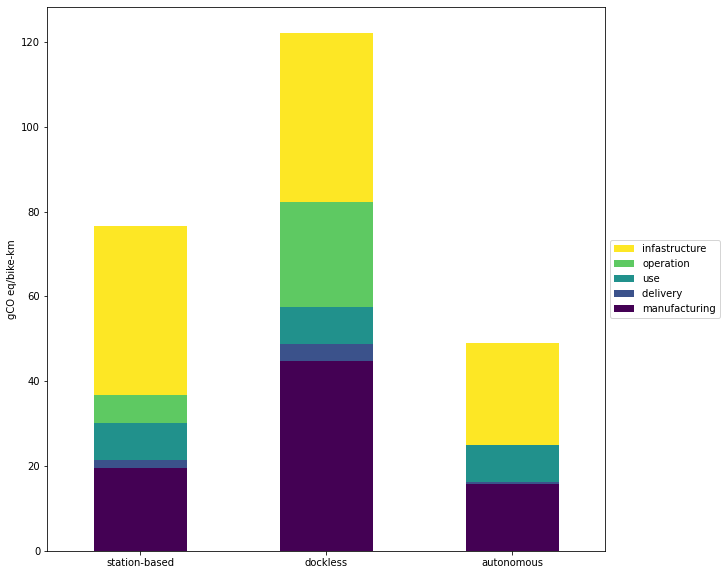

In [ ]:
#Plotting the data
data=[data_sb,data_dl,data_aut]
data=pd.DataFrame(data, index=['station-based','dockless','autonomous'])
data.plot.bar(stacked=True, rot=0,cmap="viridis",figsize=(10, 10))
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,3,2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.ylabel('gCO eq/bike-km')

#Print totals
sb_impact=data_sb.sum()
dl_impact=data_dl.sum()
aut_impact=data_aut.sum()
print('Station-based sytsem gCO eq/bike-km: %.2f' % sb_impact)
print('Dockless sytsem gCO eq/bike-km: %.2f' % dl_impact)
print('Autonomous sytsem gCO eq/bike-km: %.2f' % aut_impact)

### Overall environmental impacts

The results in the previous chart reflect the environmental impacts of station-based, dockless and autonomous BSS. However, these systems' overall environmental impact will depend on the **mobility modes displaced** by the bike-sharing trips.

Mode shift is very dependent on location, time, and travel context, being very much trip-specific. To account for this variability, we have included a range of reported mode shifts from different countries gathered by Teixeira et al. [REF](https://www.tandfonline.com/doi/abs/10.1080/01441647.2020.1841328?casa_token=YsyE0vV_ywgAAAAA:a-a1HWCFgRZ4JAQTiwacl_qaqP0ysqZXXwcEIPZ7ExIZidPOX6PZ_LuazKI9zX8JsJmt-3dVEc_8NQ).

In [ ]:
mode_shift_url='https://raw.githubusercontent.com/NaroaCS/data/main/environmental-impacts/ModeShift-MAS552.csv'
mode_shift = pd.read_csv(mode_shift_url)
mode_shift

,City,Car_Motorcycle,Taxi,PublicTransit,Walking,Own_Bike,New_Trip
0,Birsbane,0.21,0.03,0.43,0.23,0.08,0.01
1,Melbourne,0.19,0.02,0.41,0.27,0.09,0.01
2,Hangzhou,0.08,0.05,0.59,0.19,0.10,NaN
3,Nanjing,0.15,0.04,0.19,0.47,0.15,NaN
4,Barcelona,0.10,NaN,0.51,0.26,0.06,NaN
5,Dublin,0.03,NaN,0.31,0.54,0.12,NaN
6,Dublin,0.20,NaN,0.35,0.46,NaN,NaN
7,Lyon,0.07,NaN,0.50,0.37,0.04,0.02
8,London,0.01,0.04,0.61,0.29,0.05,0.01
9,London,0.02,0.04,0.58,0.26,0.08,0.04


Taking these mode shifts into account, the GHG emission reduction percentage for each scenario are calculated below.

The impacts for the substituted modes have been adapted from [ITF](https://www.itf-oecd.org/good-go-assessing-environmental-performance-new-mobility) for the electricity mix of the United States:
* Car (ICEV): 161.97  g Co2 eq/km
* Taxi (ICEV): 358.47 g Co2 eq/km
* Public Transit (ICE Bus): 91.43 g Co2 eq/km
* Walking: 0 g Co2 eq/km
* Own Bike: 16 g Co2 eq/km


In [ ]:
#Convernt NaN to 0%
mode_shift.fillna(0, inplace=True)

#The overall impact will be all trips + new trips in shared bikes - the previous mix
mode_shift['Station-based [%]'] =  (1*sb_impact + mode_shift['New_Trip']*sb_impact)  - (mode_shift['Car_Motorcycle']*161.97 + mode_shift['Taxi']*358.47 + mode_shift['PublicTransit']*91.43 + mode_shift['Walking']*0.0 + mode_shift['Own_Bike']*16.0)
mode_shift['Dockless [%]'] =  (1*dl_impact + mode_shift['New_Trip']*dl_impact)  - (mode_shift['Car_Motorcycle']*161.97 + mode_shift['Taxi']*358.47 + mode_shift['PublicTransit']*91.43 + mode_shift['Walking']*0.0 + mode_shift['Own_Bike']*16.0)
mode_shift['Autonomous [%]'] =  (1*aut_impact + mode_shift['New_Trip']*aut_impact)  - (mode_shift['Car_Motorcycle']*161.97 + mode_shift['Taxi']*358.47 + mode_shift['PublicTransit']*91.43 + mode_shift['Walking']*0.0 + mode_shift['Own_Bike']*16.0)
mode_shift

,City,Car_Motorcycle,Taxi,PublicTransit,Walking,Own_Bike,New_Trip,Station-based [%],Dockless [%],Autonomous [%]
0,Birsbane,0.21,0.03,0.43,0.23,0.08,0.01,-8.003966,37.932348,-35.939524
1,Melbourne,0.19,0.02,0.41,0.27,0.09,0.01,0.488734,46.425048,-27.446824
2,Hangzhou,0.08,0.05,0.59,0.19,0.10,0.00,-9.831994,35.649505,-37.490962
3,Nanjing,0.15,0.04,0.19,0.47,0.15,0.00,18.186806,63.668305,-9.472162
4,Barcelona,0.10,0.00,0.51,0.26,0.06,0.00,12.806506,58.288005,-14.852462
5,Dublin,0.03,0.00,0.31,0.54,0.12,0.00,41.470406,86.951905,13.811438
6,Dublin,0.20,0.00,0.35,0.46,0.00,0.00,12.198306,57.679805,-15.460662
7,Lyon,0.07,0.00,0.50,0.37,0.04,0.02,20.431762,66.822891,-7.780385
8,London,0.01,0.04,0.61,0.29,0.05,0.01,4.827934,50.764248,-23.107624
9,London,0.02,0.04,0.58,0.26,0.08,0.04,7.768918,55.069677,-20.996408
